Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Number of validation batches: 26
Number of test batches: 6
(32, 5, 5, 1280)
(32, 1280)
(32, 1)
Epoch 1/10


2021-12-28 22:46:05.775061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 0.7527 - accuracy: 0.5465

2021-12-28 22:46:08.465748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 4s 57ms/step - loss: 0.7527 - accuracy: 0.5465 - val_loss: 0.5327 - val_accuracy: 0.7005
Epoch 2/10
63/63 [==============================] - 3s 48ms/step - loss: 0.5066 - accuracy: 0.7330 - val_loss: 0.3746 - val_accuracy: 0.8144
Epoch 3/10
63/63 [==============================] - 3s 49ms/step - loss: 0.3752 - accuracy: 0.8095 - val_loss: 0.2877 - val_accuracy: 0.8800
Epoch 4/10
63/63 [==============================] - 3s 48ms/step - loss: 0.2903 - accuracy: 0.8705 - val_loss: 0.2331 - val_accuracy: 0.9097
Epoch 5/10
63/63 [==============================] - 3s 48ms/step - loss: 0.2486 - accuracy: 0.8945 - val_loss: 0.1974 - val_accuracy: 0.9356
Epoch 6/10
63/63 [==============================] - 3s 47ms/step - loss: 0.2119 - accuracy: 0.9135 - val_loss: 0.1650 - val_accuracy: 0.9468
Epoch 7/10
63/63 [==============================] - 3s 48ms/step - loss: 0.1842 - accuracy: 0.9265 - val_loss: 0.1417 - val_accuracy: 0.9579
Epoch 8/10
63/63 [======

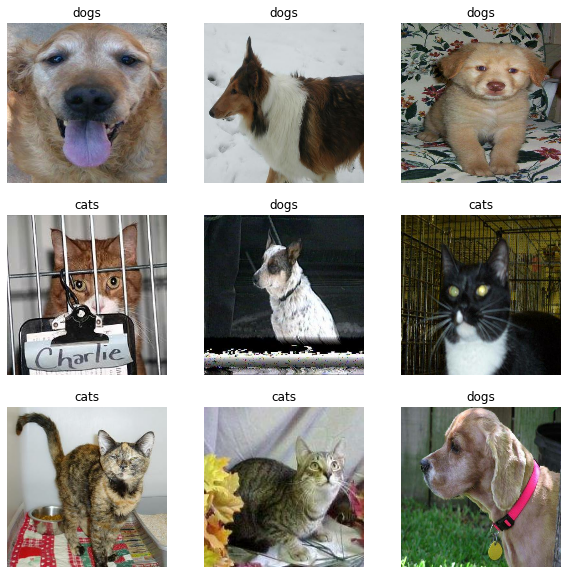

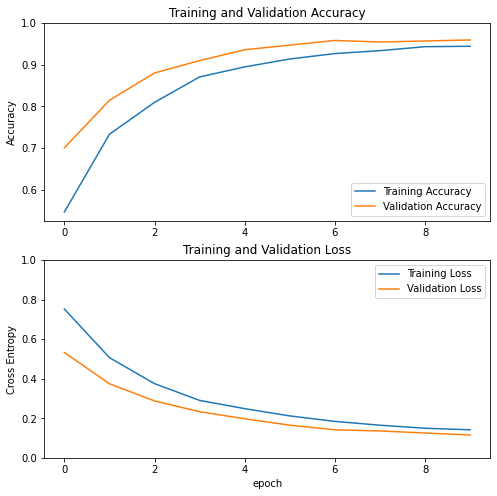

2021-12-28 22:46:38.463033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Predictions:
 [0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1]
Labels:
 [0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1]


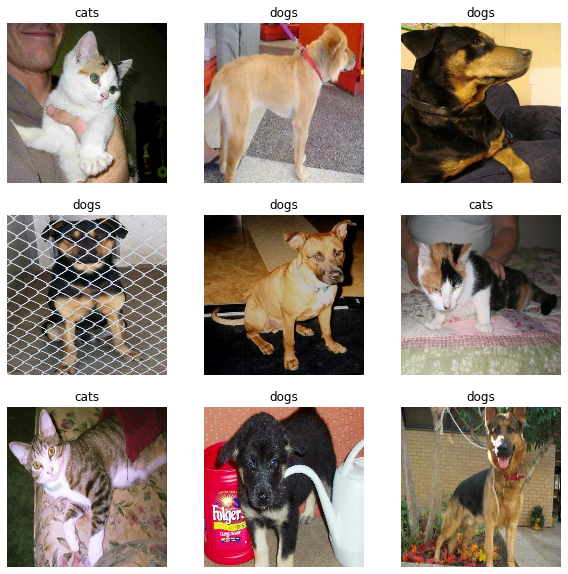

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Applying data augmentation
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
# ])
# for image, _ in train_dataset.take(1):
#     plt.figure(figsize=(10, 10))
#     first_image = image[0]
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#         plt.imshow(augmented_image[0] / 255)
#         plt.axis('off')

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# Base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(160, 160, 3))
# x = data_augmentation(inputs)
x = inputs
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

# MobileNetV2 basic evaluating
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
model.summary()

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [59]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()


# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
print(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
#
# plt.figure(figsize=(10, 10))
# for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(image_batch[i].astype("uint8"))
#     plt.title(class_names[predictions[i]])
#     plt.axis("off")

tf.Tensor(
[0.75293255 0.9805211  0.04295285 0.7602     0.0306991  0.9292301
 0.06296349 0.06247514 0.02449111 0.04089667 0.91831064 0.02095162
 0.93492687 0.57687503 0.9817956  0.97455084 0.01183807 0.97834057
 0.00748422 0.0027081  0.92004806 0.00606144 0.9448943  0.8814374
 0.88641953 0.89668936 0.84353966 0.37535462 0.76976657 0.30760232
 0.69924706 0.9841875 ], shape=(32,), dtype=float32)
Predictions:
 [1 1 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1]
Labels:
 [1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1]


In [70]:
## Applying FGSM data augmentation
loss_object = tf.keras.losses.CategoricalCrossentropy()
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

def preprocess(process_image):
    process_image = tf.cast(process_image, tf.float32)
    process_image = tf.image.resize(process_image, (160, 160))
    process_image = tf.keras.applications.mobilenet_v2.preprocess_input(process_image)
    process_image = process_image[None, ...]
    return process_image

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = base_model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

for images, labels in train_dataset.take(1):
    for i in range(1):

        image = preprocess(images[i])
        print(get_imagenet_label(base_model.predict(image)))
        label = labels[i]
        print(label)
        # perturbations = create_adversarial_pattern(image, label)
        # plt.imshow(perturbations[0] * 0.5 + 0.5)


# label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
# label = tf.reshape(label, (1, image_probs.shape[-1]))
#
# perturbations = create_adversarial_pattern(image, label)
# plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (1, 5, 5, 1280)